# Important Library Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Helper Function Implementations

In [2]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            
            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            
            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

# Prepare Transforms for Data Augmentation

In [3]:
# data_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.5),  # 50% chance to shift
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=20)], p=0.5),  # 50% chance to shear
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.5),  # 50% chance to scale
#     transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Always applied (for zoom)
#     transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
#     transforms.RandomVerticalFlip(p=0.5),  # 50% chance to flip vertically
#     transforms.ToTensor()
# ])

data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.4),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=20)], p=0.4),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.4),
        transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.4),
        transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.4),
    ]),
    transforms.ToTensor()
])

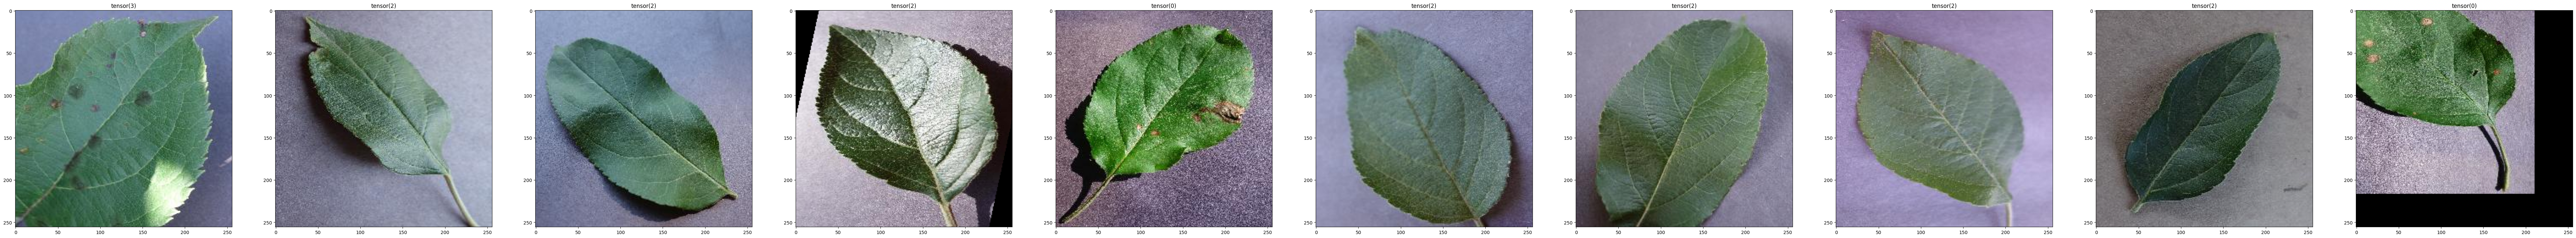

In [5]:
dataset = ImageFolder(root="Original_Dataset\Testing", transform=data_transforms)

# Define data loader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
data_iter = iter(dataloader) 
augmented_images, labels = next(data_iter)  # Ignore labels, we only need images

augmented_images = augmented_images.permute(0, 2, 3, 1)

fig, axes = plt.subplots(1, 10, figsize=(100, 50))

for i in range(10):
    axes[i].imshow(augmented_images[i])
    axes[i].set_title(str(labels[i]))

# plt.imshow(augmented_images[0])
plt.show()

# Load Training, Validation, and Testing Images

In [24]:
LABELS = ["Black Rot", "Cedar Rust", "Healthy", "Scab"]

BATCH_SIZE = 50
DEVICE = torch.device("cuda")
folder_path = "Original_Dataset"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model Construction

In [7]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        
        conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='valid').to(DEVICE)
        relu1 = nn.ReLU().to(DEVICE)

        pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(DEVICE)

        conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding='valid').to(DEVICE)
        relu2 = nn.ReLU().to(DEVICE)

        conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding='valid').to(DEVICE)
        relu3 = nn.ReLU().to(DEVICE)

        dropout = nn.Dropout(0.4).to(DEVICE)

        flatten = nn.Flatten().to(DEVICE)

        fcn1 = nn.Linear(in_features=7200, out_features=16).to(DEVICE)
        relu4 = nn.ReLU().to(DEVICE)

        fcn2 = nn.Linear(in_features=16, out_features=4).to(DEVICE)
        softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, pool, conv2, relu2, pool, conv3, relu3, pool, dropout, flatten, fcn1, relu4, fcn2, softmax)

    def forward(self, x):
        return self.layers(x)
    

def categorical_cross_entropy(y_pred, y_true):
    return nn.NLLLoss()(torch.log(y_pred), y_true)

# Model Training

### Perform Training

In [11]:
NUM_EPOCHS =  250
learning_rate = 0.0001
adam_beta1 = 0.9
adam_beta2 = 0.999

model = DeepCNN()

model.train() 
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2))
# criterion = nn.CrossEntropyLoss()

epoch_loss = []
train_loss = []
validaction_acc = []

for epoch in range(NUM_EPOCHS):
    print("Epoch: %d" % epoch)
    for step_num, (batch, labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)
        
        pred = model(batch)
        optimizer.zero_grad()
        loss = categorical_cross_entropy(y_pred=pred, y_true=labels)
        # loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        if (step_num + 1) % 13 == 0:
            # Perform validation and store accuracy
            validation_accuracy = validate_model(model=model, val_loader=val_loader, device=DEVICE)
            validaction_acc.append(validation_accuracy)

        train_loss.append(loss.item())

    # Track average loss for each epoch
    epoch_loss.append(sum(train_loss) / len(train_loss))
    print(f"Epoch loss: {epoch_loss[-1]}")

Epoch: 0
Epoch loss: 1.246399752298991
Epoch: 1
Epoch loss: 1.2095655467775133
Epoch: 2
Epoch loss: 1.1757653465977422
Epoch: 3
Epoch loss: 1.1347698334190581
Epoch: 4
Epoch loss: 1.0877212765481736
Epoch: 5
Epoch loss: 1.0343440382568925
Epoch: 6
Epoch loss: 0.9861854956263587
Epoch: 7
Epoch loss: 0.9449177086353302
Epoch: 8
Epoch loss: 0.9074963847796123
Epoch: 9
Epoch loss: 0.8745128851466709
Epoch: 10
Epoch loss: 0.8453261991341908
Epoch: 11
Epoch loss: 0.8196887035060811
Epoch: 12
Epoch loss: 0.7949027426731892
Epoch: 13
Epoch loss: 0.7739346006559947
Epoch: 14
Epoch loss: 0.7541296894020505
Epoch: 15
Epoch loss: 0.7348492937783401
Epoch: 16
Epoch loss: 0.7179476489818174
Epoch: 17
Epoch loss: 0.7009150373163047
Epoch: 18
Epoch loss: 0.686016859105456
Epoch: 19
Epoch loss: 0.6714022613565127
Epoch: 20
Epoch loss: 0.6587937728122428
Epoch: 21
Epoch loss: 0.6450770706540406
Epoch: 22
Epoch loss: 0.6326092222750475
Epoch: 23
Epoch loss: 0.6217303572981446
Epoch: 24
Epoch loss: 0.6102

### Plot Model Loss

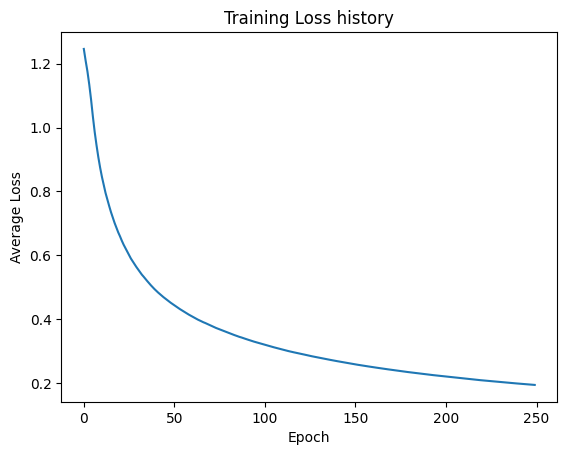

In [12]:
plt.title("Training Loss history")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(epoch_loss)
plt.show()

In [23]:
torch.save(model.state_dict(), "original_model_96.pth")

# Model Testing

In [31]:
accuracy = test_model(model=model, test_loader=test_loader, device=DEVICE)
print("Model accuracy: %f" % accuracy)

# 150 epochs gets 94% accuracy
# 200 epochs gets 91%-94% accuracy

Model accuracy: 95.924765


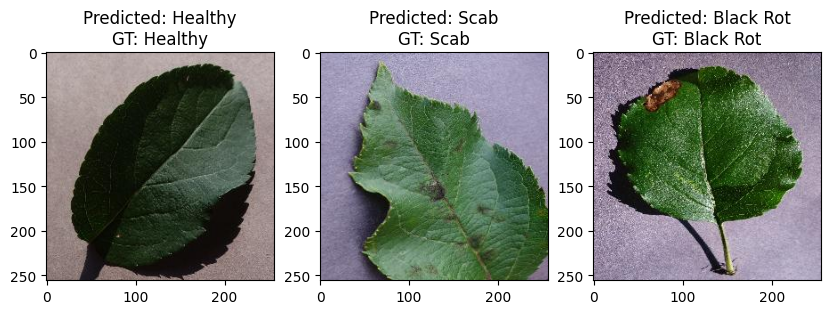

In [32]:
data = ImageFolder(root="Original_Dataset\Testing", transform=transforms.Compose([transforms.ToTensor()]))

# Define data loader
dataloader = DataLoader(data, batch_size=32, shuffle=True, num_workers=4)
data_iter = iter(dataloader) 
images, labels = next(data_iter)  # Ignore labels, we only need images

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
y_pred = model(images.to(DEVICE)).argmax(dim=1)

for i in range(3):
    image = images[i].permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title("Predicted: " + LABELS[y_pred[i]] + "\nGT: " + LABELS[labels[i]])

# plt.imshow(augmented_images[0])
plt.show()

In [ ]:
# Some model loading tests to make sure things were done right
new_model = DeepCNN()
new_model.load_state_dict(torch.load("original_model_overfit.pth"))

acc = test_model(model, test_loader, DEVICE)
print(acc)

19.74921630094044
